<img src="logo.png"/>

# Deconvolution microscopy using Python

The first step is to define the problem. Consider the standard image formation model for fluoresence microscopy:

$$D(x,y)= S(x,y) \cdot E(x,y) \otimes PSF(x,y) + N(x,y)$$
where $D(x,y)$ is the image formed on the camera; $S(x,y)$ is the distribution of Fluorophores in the sample; $E(x,y)$ is the intensity distribution of the excitation light; $PSF(x,y)$ is the Point Spread Function of the system; and $N(x,y)$ is a term defining the random noise. At this stage we have simplified things by considering only 2D imaging with a $1 \times$ magnification of the system such that the coordinates (x,y) at the camera correspond to coordinates (x,y) in the sample.   
The goal of deconvolution microscopy is to try to recover the best estimate of $S(x,y)$ from the image $D(x,y)$. 

First we import all the packages we will use:

In [35]:
w = 512
wave = 680
kx =10
px = 50
NA = 1.2

In [36]:
import numpy as np
import numpy.fft
import skimage
from skimage import io
from matplotlib import pyplot as plt

Now lets import an model image we can work from and use the PSF function to calculate a theoretical PSF:

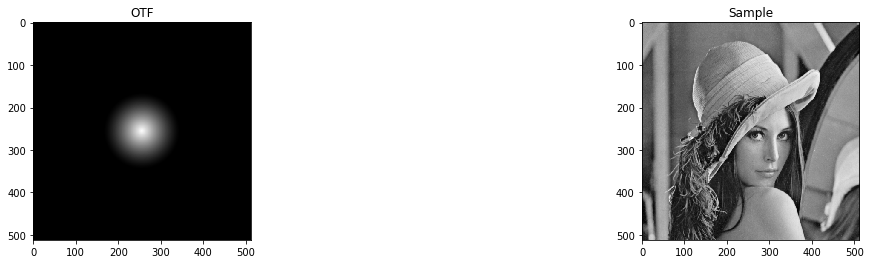

In [115]:
from DrawPSFs import * 

OTF = getSimpleOTF(w,px,NA,wave)
OTF = np.fft.fftshift(OTF)

plt.figure(figsize=(20, 4))
plt.subplot(1,2,1)
plt.title('OTF')
plt.imshow(OTF, cmap='gray')

sample = skimage.io.imread('lena.png')
sample = sample.astype('float')
sampl = sample/np.amax(sample)
plt.subplot(1,2,2)
plt.title('Sample')
plt.imshow(sample, cmap='gray')
plt.show()

And then create a simulated widefield image of the sample:

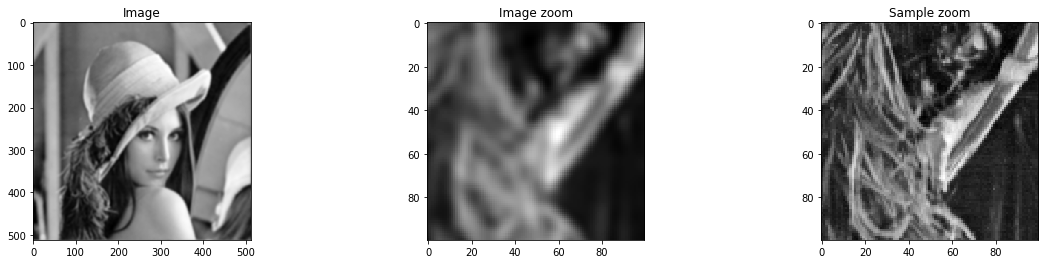

In [119]:
FTs = np.fft.fft2(sample)
FTs = np.fft.fftshift(FTs)
FT = OTF*FTs
D = abs(np.fft.ifft2(np.fft.fftshift(FT)))
D = D/np.amax(D)

plt.figure(figsize=(20, 4))
plt.subplot(1,3,1)
plt.title('Image')
plt.imshow(D, cmap='gray')


plt.subplot(1,3,2)
plt.title('Image zoom')
plt.imshow(D[300:400,100:200], cmap='gray')

plt.subplot(1,3,3)
plt.title('Sample zoom')
plt.imshow(sample[300:400,100:200], cmap='gray')
plt.show()

h, w = sample.shape

But to more accurately represent the image formation we need to add noise to these images. There are three types of noise encountered in imaging: Gaussian noise from the electronics of the camera, Poisson noise due to the low number of photons collected; and shot noise from hot and dead pixels on the sensor. Using high quality scientific cameras (sCMOS / EMCCD), the Gaussian noise - which otherwise dominates in imaging - is relatively weak and the Poisson noise is the main source of noise.
We will add both Gaussian and Poisson noise to the images before we begin deconvolution. 

0.5060680589241956
1.5253398676236576


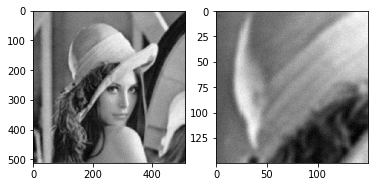

In [120]:
# we can use the numpy.random library to generate n-dimensional Gaussian distributions
from numpy import random
mu = 0.5
var = 0.01

gaussian = np.random.normal(mu, var, sample.shape)
print(gaussian[100,100])
D = D+gaussian
print(np.amax(D))
plt.subplot(1,2,1)
plt.imshow(D, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(D[100:250,100:250], cmap='gray')
plt.show()

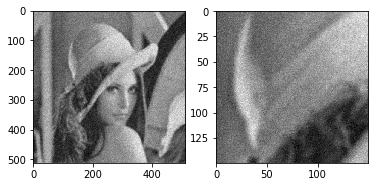

In [122]:

D = D+ numpy.random.poisson(D*2000)
D = D/np.amax(D)
plt.subplot(1,2,1)
plt.imshow(D, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(D[100:250,100:250], cmap='gray')
plt.show()

In [ ]:
Now we have a noisy image we can begin to consider deconvolution methods.